## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size):
    if not os.path.exists(data_path+'/train'): download_cifar10(data_path)

    # Data loading code
    traindir = os.path.join(data_path, 'train')
    valdir = os.path.join(data_path, 'test')
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    tfms = [transforms.ToTensor(), normalize]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)
    val_tfms = transforms.Compose(tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, val_tfms)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs*2, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:
data = torch_loader(str(PATH), sz)

In [6]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=7, lr=(.05,.7), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=1, lr=.8, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.7,.05), lr_decay=DecayType.COSINE, momentum=(0.85,0.95)),
    TrainingPhase(**def_phase, epochs=4, lr=(.05,.0001), lr_decay=DecayType.COSINE, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.688343   2.590536   0.3596    
    1      1.215289   1.159745   0.6122                   
    2      0.936403   0.971305   0.6595                    
    3      0.812859   1.020512   0.674                     
    4      0.711921   0.931073   0.7082                    
    5      0.684163   0.94897    0.708                     
    6      0.658383   0.972784   0.6993                    
    7      0.626793   0.90801    0.7344                    
    8      0.431191   0.420832   0.8563                    
    9      0.352752   0.458748   0.8457                    
    10     0.304916   0.377956   0.8723                    
    11     0.263483   0.377373   0.8688                    
    12     0.228631   0.312195   0.8958                    
    13     0.183145   0.294325   0.9086                    
    14     0.149064   0.273901   0.9157                    
    15     0.130598   0.270332   0.9169                   

[array([0.26827]), 0.9214999992370605]

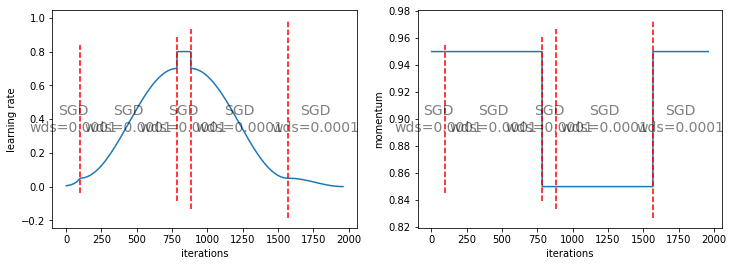

In [7]:
learn.sched.plot_lr()

In [8]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=7, lr=(.05,.7), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=2, lr=.8, momentum=0.85),
    TrainingPhase(**def_phase, epochs=8, lr=(.7,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95)),
    TrainingPhase(**def_phase, epochs=2, lr=(.01,.0001), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.689347   3.60225    0.2971    
    1      1.286511   1.464817   0.5628                   
    2      0.990399   1.041087   0.6527                    
    3      0.827644   1.03326    0.6778                    
    4      0.752201   1.002585   0.6651                    
    5      0.703729   0.885871   0.7252                    
    6      0.652956   0.848663   0.7302                    
    7      0.592267   0.86414    0.7318                    
    8      0.415684   0.466636   0.8452                    
    9      0.348408   0.392049   0.8675                    
    10     0.309776   0.342189   0.8863                    
    11     0.277888   0.3413     0.8862                    
    12     0.246544   0.333448   0.8903                    
    13     0.213419   0.317795   0.8961                    
    14     0.172292   0.281904   0.9084                    
    15     0.13499    0.281259   0.9145                   

[array([0.26972]), 0.9207000016212463]

In [9]:
m = wrn_22_cat()
learn = ConvLearner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd=1e-4
lr=.6
learn.clip = 1e-1
def_phase = {'opt_fn':optim.SGD, 'wds':wd}
# TODO: add momentum
lr=0.6
phases = [
    TrainingPhase(**def_phase, epochs=1, lr=(.005,.05), lr_decay=DecayType.EXPONENTIAL, momentum=0.95),
    TrainingPhase(**def_phase, epochs=6, lr=(.05,.7), lr_decay=DecayType.COSINE, momentum=(0.95,0.85)),
    TrainingPhase(**def_phase, epochs=4, lr=.8, momentum=0.85),
    TrainingPhase(**def_phase, epochs=7, lr=(.7,.01), lr_decay=DecayType.COSINE, momentum=(0.85,0.95)),
    TrainingPhase(**def_phase, epochs=3, lr=(.01,.0005), lr_decay=DecayType.LINEAR, momentum=(0.95))]

learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.724954   2.410347   0.3611    
    1      1.36196    1.271085   0.5669                   
    2      1.056469   1.066045   0.6402                   
    3      0.866396   1.255315   0.6236                    
    4      0.792224   1.682962   0.5536                    
    5      0.729181   1.03411    0.6937                    
    6      0.680069   0.721459   0.7672                    
    7      0.473963   0.441238   0.8507                    
    8      0.394682   0.571208   0.8182                    
    9      0.357743   0.422121   0.8571                    
    10     0.331577   0.510588   0.8344                    
    11     0.295164   0.373635   0.8773                    
    12     0.271494   0.417378   0.8634                    
    13     0.231684   0.324791   0.8933                    
    14     0.191831   0.354465   0.8883                    
    15     0.148031   0.278688   0.9114                    

[array([0.26849]), 0.9204999996185302]